# The COVIDNetX challenge

<img src="https://www.psycharchives.org/retrieve/096175aa-f7f2-4970-989d-d934c30b5551" alt="drawing" width="400"/>

The following is a classification challenge using the [COVID-X dataset](https://github.com/lindawangg/COVID-Net/blob/master/docs/COVIDx.md).
The goal is to predict whether a person has COVID-19 or not based on chest X-RAY images.

There are two different categories: `positive` and `negative`. `positive` means a person has COVID-19, `negative` means a person
has not COVID-19.

The metric we use is F1 (https://en.wikipedia.org/wiki/F1_score). The goal is to maximize F1.

The data contains images with their associated labels.

## EDA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns

### Load Data

In [2]:
data_dir = 'data/'
# data_dir = 'data_subset/'

df = pd.read_csv(data_dir+'train.csv')
test_df = pd.read_csv(data_dir+'submission_valid.csv')

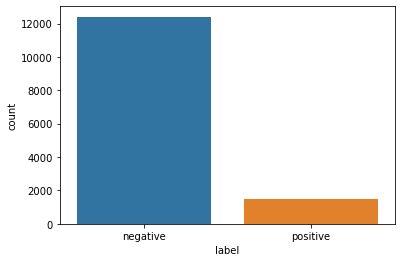

In [3]:
(df.label.value_counts())/len(df)
sns.countplot(data=df, x='label');

### Add "img_shape" Column

In [4]:
df['img_shape'] = df.image.apply(lambda img: Image.open(data_dir+'train/'+img).size)
df.sample(10)

,image,label,img_shape
6533,fb7cc2ce787d24a4d9ec5126260dde64.png,negative,"(4248, 3480)"
5375,2e3e1f9d49ab13924ab66021fd628d02.png,positive,"(256, 256)"
5165,03d9d1b96620572cf9b249f493a9eacd.png,negative,"(1024, 1024)"
7388,c5f0651a8bcd7028d8288af9d0287a59.png,negative,"(1024, 1024)"
8598,848beb0f2f107890a8bd144a37318353.png,negative,"(1024, 1024)"
5710,390b0fd3c73f9eb3f76d065899d0c820.png,negative,"(1024, 1024)"
8697,dad87c822513dc4b640647c8a3f61cb5.png,negative,"(1024, 1024)"
13343,badbda77fc7468658435c0c74a4a1d98.png,negative,"(1024, 1024)"
7598,bfe22175adaa9d5f6ca3f6736b6501d5.png,negative,"(1024, 1024)"
13619,eb2aabfa43daf0ead3dc4d8189de5a5c.png,negative,"(1024, 1024)"


### Image Shapes

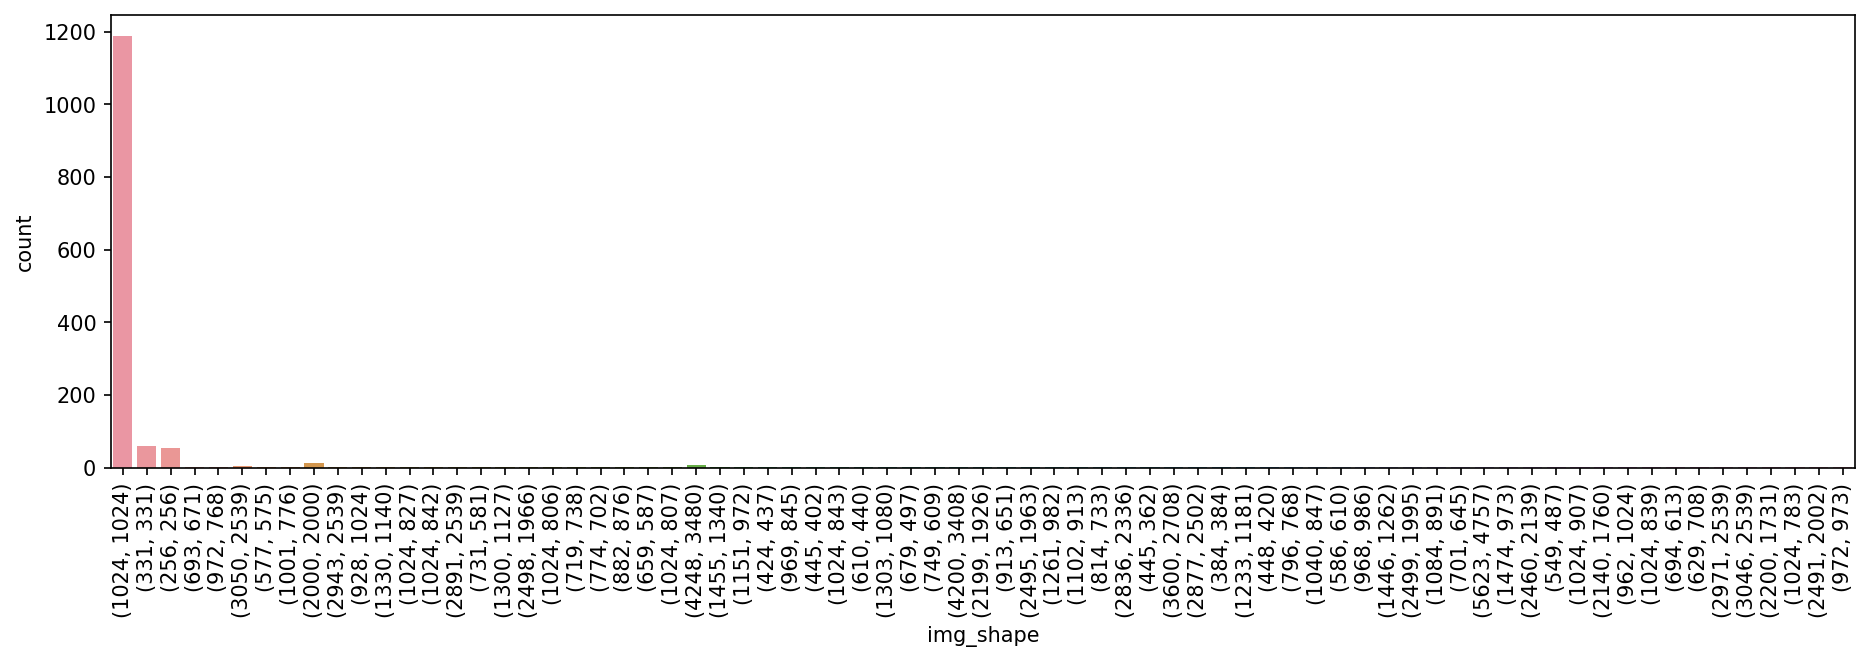

In [5]:
fig = plt.figure(figsize=(15,4), dpi=150)
sns.countplot(data=df.sample(frac=0.1, random_state=42), x='img_shape');
plt.xticks(rotation=90);

In [6]:
df.img_shape.value_counts()/len(df)

(1024, 1024)    0.866638
(331, 331)      0.037364
(256, 256)      0.034706
(2000, 2000)    0.006395
(3050, 2539)    0.003665
                  ...   
(1650, 1816)    0.000072
(2891, 2539)    0.000072
(1787, 1800)    0.000072
(597, 531)      0.000072
(1052, 1056)    0.000072
Name: img_shape, Length: 580, dtype: float64

**NOTE**: 87% images have shape: 1024x1024

### Covid "positive" Image Shapes

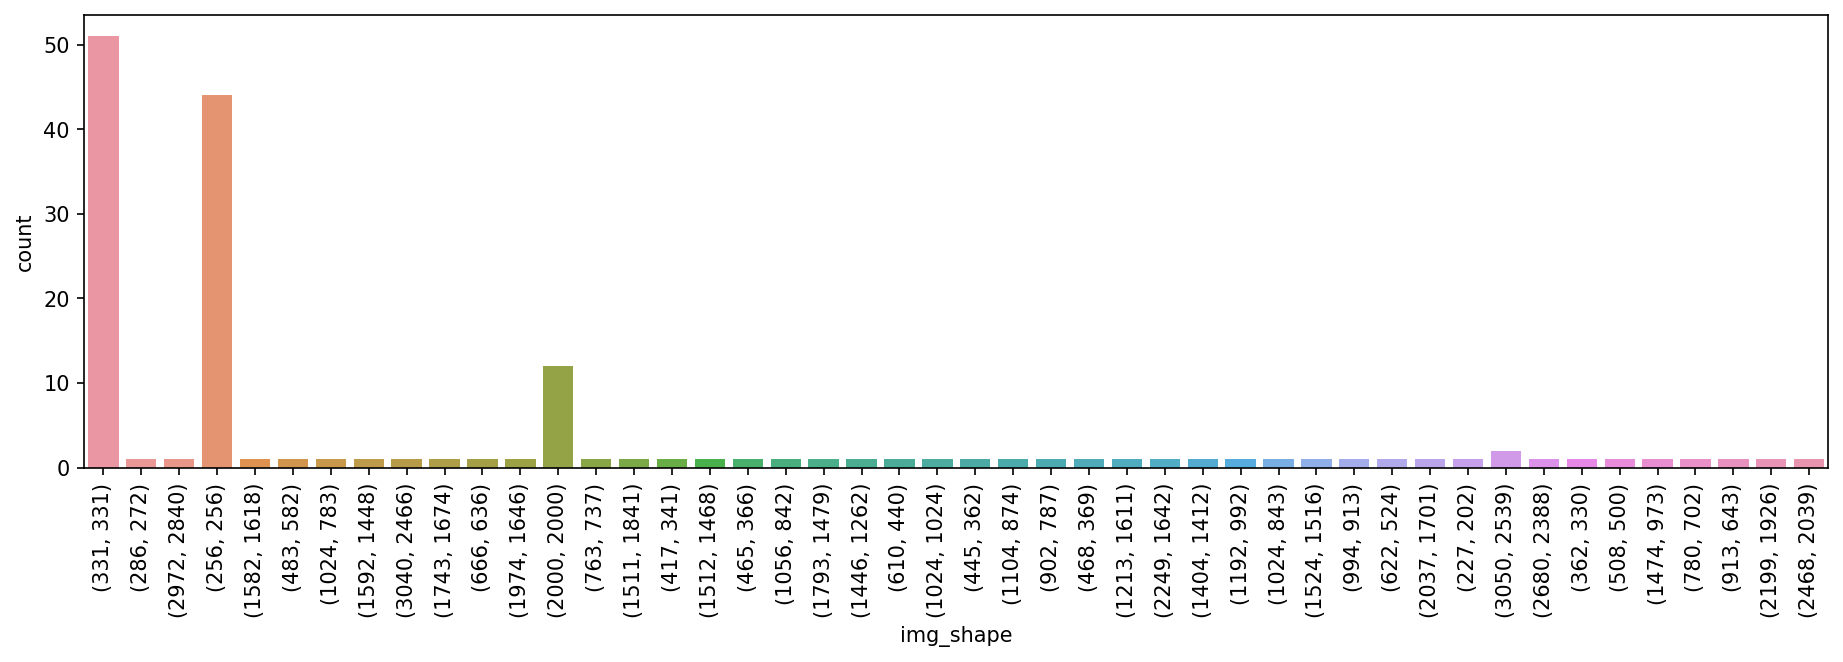

In [7]:
pos = df[df.label=='positive']
fig = plt.figure(figsize=(15,4), dpi=150)
sns.countplot(data=pos.sample(frac=0.1, random_state=42), x='img_shape');
plt.xticks(rotation=90);

In [8]:
pos.img_shape.value_counts()/len(pos)

(331, 331)      0.344371
(256, 256)      0.319868
(2000, 2000)    0.044371
(1084, 891)     0.018543
(1024, 1024)    0.005298
                  ...   
(2386, 1835)    0.000662
(994, 913)      0.000662
(1723, 1466)    0.000662
(3040, 2466)    0.000662
(1799, 1472)    0.000662
Name: img_shape, Length: 363, dtype: float64

In [9]:
pos_non_1024x1024 = pos[pos.img_shape!=(1024,1024)]
print(f"% of covid positive images which are not of 1024x1024 shape: {len(pos_non_1024x1024)/len(pos)}")

% of covid positive images which are not of 1024x1024 shape: 0.9947019867549669


**NOTE**: 99% X-ray images of covid positive cases are _not_ of 1024x1024 shape

## Data Preprocessing

### Split Data

In [10]:
from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)
valid_df, test_df = train_test_split(valid_df, test_size=0.5, random_state=42)

In [11]:
# train_df_pos = len(train_df[train_df.label=='positive'])
# train_df_balanced = pd.concat([train_df[train_df.label=='positive'], 
#                                train_df[train_df.label=='negative'].sample(2*train_df_pos)],
#                                ignore_index=True)
# train_df_balanced.label.value_counts()

In [12]:
train_df_pos = train_df[train_df.label=='positive']
train_df_neg = train_df[train_df.label=='negative']

In [60]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = 256
batch_size = 1#000

datagen = ImageDataGenerator(
    rescale=1./255, 
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    )

train_neg_datagen = datagen.flow_from_dataframe(
    train_df_neg,
    data_dir+'train/', 
    target_size=(img_size,img_size), 
    x_col='image', 
    y_col='label', 
    batch_size=batch_size, 
    class_mode='categorical',
    shuffle=True)
train_pos_datagen = datagen.flow_from_dataframe(
    train_df_pos,
    data_dir+'train/', 
    target_size=(img_size,img_size), 
    x_col='image', 
    y_col='label', 
    batch_size=batch_size, 
    class_mode='categorical',
    shuffle=True)

valid_datagen = datagen.flow_from_dataframe(
    valid_df, 
    data_dir+'train/', 
    target_size=(img_size,img_size), 
    x_col='image', 
    y_col='label', 
    batch_size=batch_size, 
    class_mode='binary',
    shuffle=True)

datagen_rescale = ImageDataGenerator(rescale=1./255)
test_datagen = datagen_rescale.flow_from_dataframe(
    test_df, 
    data_dir+'train/', 
    target_size=(img_size,img_size), 
    x_col='image', 
    y_col='label', 
    batch_size=batch_size, 
    class_mode='binary',
    shuffle=True)

Found 9958 validated image filenames belonging to 1 classes.
Found 1175 validated image filenames belonging to 1 classes.
Found 1392 validated image filenames belonging to 2 classes.
Found 1392 validated image filenames belonging to 2 classes.


In [14]:
%%time

def X_y_datagen(data_generator):
    for X, y in data_generator:
        return X.reshape(-1, img_size*img_size*3), y

X_train_neg, _ = X_y_datagen(train_neg_datagen)
X_train_pos, _ = X_y_datagen(train_pos_datagen)
for _ in range(9):
    X, y = X_y_datagen(train_pos_datagen)
    X_train_pos = np.vstack((X_train_pos, X))

X_valid, y_valid = X_y_datagen(valid_datagen)
X_test, y_test = X_y_datagen(test_datagen)

CPU times: user 12min 3s, sys: 1min 17s, total: 13min 21s
Wall time: 13min 26s


((21708, 196608), (11750, 196608), (1392, 196608), (1392, 196608), (21708,))

In [61]:
X_train = np.vstack((X_train_pos[:], X_train_neg[:]))
y_train = np.concatenate((np.ones(len(X_train_pos[:])), 
                          np.zeros(len(X_train_neg[:]))))

sum(y_train==1)/len(y_train), X_train.shape, X_train_neg.shape, X_valid.shape, X_test.shape

(0.5412751059517229,
 (21708, 196608),
 (9958, 196608),
 (1392, 196608),
 (1392, 196608))

## Model

### Random Forest

In [62]:
%%time

from sklearn.model_selection import RandomizedSearchCV

model = RandomForestClassifier(n_estimators=100, min_samples_split=10,
                               random_state=42, n_jobs=-1, verbose=1)
                               
model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   35.4s


CPU times: user 31min 43s, sys: 48.5 s, total: 32min 32s
Wall time: 2min 22s


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.3min finished


RandomForestClassifier(min_samples_split=10, n_jobs=-1, random_state=42,
                       verbose=1)

############################## TRAIN ############################## 


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.2s finished


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      9958
         1.0       1.00      1.00      1.00     11750

    accuracy                           1.00     21708
   macro avg       1.00      1.00      1.00     21708
weighted avg       1.00      1.00      1.00     21708

############################## VALID ############################## 


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.1s finished


              precision    recall  f1-score   support

         0.0       0.98      0.92      0.95      1213
         1.0       0.61      0.85      0.71       179

    accuracy                           0.91      1392
   macro avg       0.79      0.89      0.83      1392
weighted avg       0.93      0.91      0.92      1392

############################## TEST ############################## 


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


              precision    recall  f1-score   support

         0.0       0.98      0.95      0.96      1236
         1.0       0.66      0.84      0.74       156

    accuracy                           0.93      1392
   macro avg       0.82      0.89      0.85      1392
weighted avg       0.94      0.93      0.94      1392



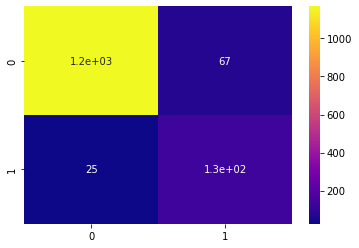

In [63]:
from sklearn.metrics import confusion_matrix, classification_report

print("############################## TRAIN ############################## ")
y_pred = model.predict(X_train)
print(classification_report(y_train, y_pred))

print("############################## VALID ############################## ")
y_pred = model.predict(X_valid)
print(classification_report(y_valid, y_pred))

print("############################## TEST ############################## ")
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='plasma', annot=True);

### XGBoost

In [ ]:
%%time

from xgboost import XGBClassifier

model = XGBClassifier(
    n_estimators=100, 
    random_state=42, 
    learning_rate=0.2,
    eval_metric='logloss',
    verbosity=1,
    use_label_encoder=False)

model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], 
    early_stopping_rounds=5, verbose=1)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='plasma', annot=True);

### CNN Model